# Averaging kernels

Example for the use of the `BayesInverse` package with a toy model. The toy model used is a diffusion of point sources in a one-dimensional medium. The state variable that is inferred is the emission rate of the point sources with known positions.

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd

In [65]:
from bayesinverse import Regression

## Create the forward model

In [66]:
# Diffusion in a medium from a point source 

In [67]:
# Gaussian dispersion
def gaussian(x, mu, sigma):
    f_x = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mu) ** 2 / sigma**2)
    return f_x


In [68]:
rng = np.random.default_rng(seed=0)

domain_size = 100

# Point sources
n = 50
mu = rng.integers(low=0, high=domain_size, size=n)
sigma = 1
x = rng.normal(loc=0, scale=1, size=n)
x_prior = np.ones(n)
x_var = np.ones(n)
# Measurement points
m = 10
# Measurement position
position = rng.random(size=m) * domain_size
y_var = np.ones(m) * 0.1


In [69]:
K = np.zeros((m, n))
for i, position_i in enumerate(position):
    for j, (mu_j, x_j) in enumerate(zip(mu, x)):
        K[i, j] = gaussian(position_i, mu_j, sigma=sigma)

In [70]:
# Measurement
y = K @ x + rng.normal(scale=y_var)

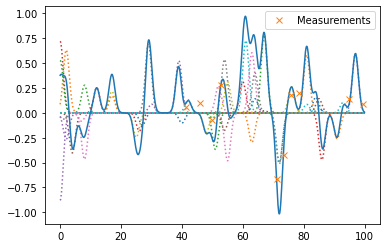

In [71]:
# Visualize
x_vis = np.linspace(0, domain_size, 1000)
y_vis = np.zeros_like(x_vis)
for i, (mu_i, x_i) in enumerate(zip(mu, x)):
    gauss_i = x_i * gaussian(x_vis, mu_i, sigma)
    plt.plot(x_vis, gauss_i, ":")
    y_vis += gauss_i
plt.plot(x_vis, y_vis)
plt.plot(position, y, "x", label="Measurements")
plt.legend()

In [72]:
regression = Regression(
    y=y,
    K=K,
    x_prior=x_prior,
    x_covariance=x_var,
    y_covariance=y_var,
)

In [73]:
x_est, res, rank, s = regression.fit()

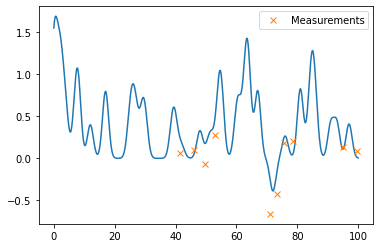

In [74]:
# Visualize
x_vis = np.linspace(0, domain_size, 1000)
y_vis = np.zeros_like(x_vis)
for i, (mu_i, x_i) in enumerate(zip(mu, x_est)):
    gauss_i = x_i * gaussian(x_vis, mu_i, sigma)
    y_vis += gauss_i
plt.plot(x_vis, y_vis)
plt.plot(position, y, "x", label="Measurements")
plt.legend()

In [75]:
averaging_kernel = regression.get_averaging_kernel()

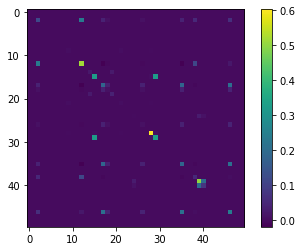

In [76]:
im = plt.imshow(averaging_kernel)
plt.colorbar(im)

## Sensitivity of the averaging kernels to prior variance and measurement variance

In [77]:
def get_function(regression, mode):
    function_dict = {
        "inv": regression.get_averaging_kernel,
        "pinv": regression.get_averaging_kernel_testing,
    }
    return function_dict[mode]


def get_averaging_kernel(alpha_list, mode="inv"):
    averaging_kernel_list = []
    for alpha in alpha_list:
        regression = Regression(
            y=y,
            K=K,
            x_prior=x_prior,
            x_covariance=x_var,
            y_covariance=y_var,
            alpha=alpha,
        )

        averaging_kernel_list.append(get_function(regression, mode)())
    return averaging_kernel_list


In [78]:
alpha_list = [0.01, 0.1, 0.5, 1.0, 1.5]
averaging_kernel_list = get_averaging_kernel(alpha_list, mode="inv")
averaging_kernel_test_list = get_averaging_kernel(alpha_list, mode="pinv")

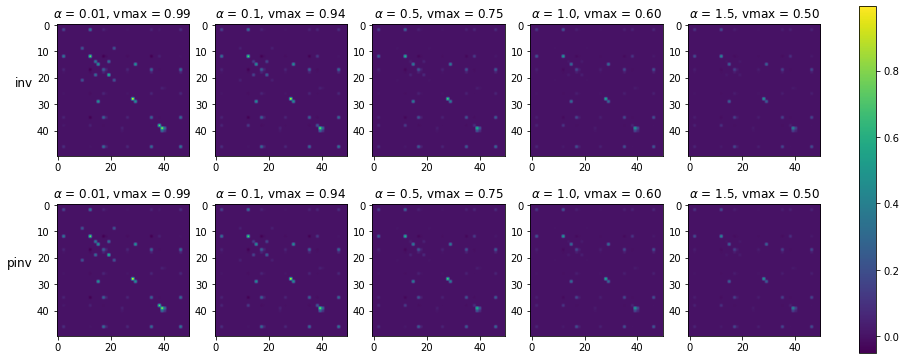

In [79]:
fig, axs = plt.subplots(
    2,
    len(averaging_kernel_list),
    figsize=(2.5 * len(averaging_kernel_list), 5),
    constrained_layout=True,
)
# fig, axs = plt.subplots(3, 2, figsize=(15, 15))

vmin = np.array(averaging_kernel_list + averaging_kernel_test_list).min()
vmax = np.array(averaging_kernel_list + averaging_kernel_test_list).max()

axs[0, 0].set_ylabel("inv", rotation=0, size="large", horizontalalignment="right")
for ax, averaging_kernel, alpha in zip(axs[0], averaging_kernel_list, alpha_list):
    im = ax.imshow(averaging_kernel, vmin=vmin, vmax=vmax)
    ax.set_title(
        r"$\alpha$ = {}, vmax = {:.2f}".format(alpha, np.array(averaging_kernel).max())
    )

axs[1, 0].set_ylabel("pinv", rotation=0, size="large", horizontalalignment="right")
for ax, averaging_kernel, alpha in zip(axs[1], averaging_kernel_test_list, alpha_list):
    im = ax.imshow(averaging_kernel, vmin=vmin, vmax=vmax)
    ax.set_title(
        r"$\alpha$ = {}, vmax = {:.2f}".format(alpha, np.array(averaging_kernel).max())
    )

plt.colorbar(im, ax=axs)
